# Titanic

#### 各項目の説明
* PassengerId – 乗客識別ユニークID
* Survived – 生存フラグ（0=死亡、1=生存）
* Pclass – チケットクラス
* Name – 乗客の名前
* Sex – 性別（male=男性、female＝女性）
* Age – 年齢
* SibSp – タイタニックに同乗している兄弟/配偶者の数
* parch – タイタニックに同乗している親/子供の数
* ticket – チケット番号
* fare – 料金
* cabin – 客室番号
* Embarked – 出港地（タイタニックへ乗った港）

##### pclass = チケットクラス

* 1 = 上層クラス（お金持ち）
* 2 = 中級クラス（一般階級）
* 3 = 下層クラス（労働階級）

##### Embarked = 各変数の定義は下記の通り

* C = Cherbourg
* Q = Queenstown
* S = Southampton

## 必要ファイルのインポート

In [61]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import GridSearchCV

In [62]:
train = pd.read_csv("../data/train.csv")
test = pd.read_csv("../data/test.csv")
print(train.shape)
print(test.shape)

(891, 12)
(418, 11)


In [63]:
%%javascript
var kernel = IPython.notebook.kernel;
var body = document.body,  
    attribs = body.attributes;
var command = "nbname = " + "'" + attribs['data-notebook-name'].value.split('.')[0] + "'";
kernel.execute(command);

<IPython.core.display.Javascript object>

In [64]:
print(nbname)

03-Model


## 前処理

In [65]:
y = train.Survived
X =  pd.concat([train.drop(['Survived'], axis=1),test])
print(X.shape)
print(y.shape)

(1309, 11)
(891,)


In [66]:
print(X.isnull().sum())

PassengerId       0
Pclass            0
Name              0
Sex               0
Age             263
SibSp             0
Parch             0
Ticket            0
Fare              1
Cabin          1014
Embarked          2
dtype: int64


In [67]:
# データの加工
X['Title'] = list(map(lambda name: name.split(',')[1].split('.')[0].lstrip(), X['Name']))
X["Cabin"] = X["Cabin"].fillna("U")
X['Cabin_Capital'] = list(map(lambda c: c[0], X['Cabin']))
X["Age"] = X["Age"].fillna(X["Age"].median())
X["Embarked"] = X["Embarked"].fillna("S")
X["Fare"] = X["Fare"].fillna(X["Fare"].median())
sepalated_age = [0, 10, 20, 30, 40, 50, 60, 70, 80, 90]
X['AgeGroup'] = pd.cut(X['Age'], sepalated_age, labels=list(map(lambda x: str(x), sepalated_age[:-1])), right=False) 

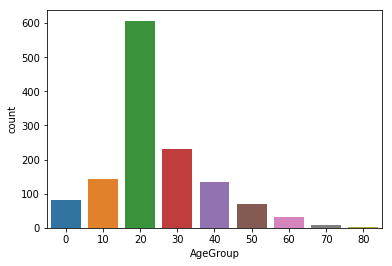

In [68]:
sns.pair

In [69]:
# 使わない項目の削除
X.drop(['Cabin','Name','Ticket','Age'], axis=1, inplace=True)

In [70]:
X['Title'] = X['Title'].where(X['Title'].isin(["Mr", "Miss", "Mrs", "Master", "Rev", "Dr"]), "Other")
X.Title.value_counts()

Mr        757
Miss      260
Mrs       197
Master     61
Other      18
Rev         8
Dr          8
Name: Title, dtype: int64

In [72]:
X.head()

,PassengerId,Pclass,Sex,SibSp,Parch,Fare,Embarked,Title,Cabin_Capital,AgeGroup
0,1,3,male,1,0,7.2500,S,Mr,U,20
1,2,1,female,1,0,71.2833,C,Mrs,C,30
2,3,3,female,0,0,7.9250,S,Miss,U,20
3,4,1,female,1,0,53.1000,S,Mrs,C,30
4,5,3,male,0,0,8.0500,S,Mr,U,30


In [73]:
#le = []
#target = ["Pclass", "Sex", "Embarked", "Title", "Cabin_Capital", "AgeGroup"]
#for i in target:
#    le = LabelEncoder()
#    le.fit(X[i])
#    X[i] = le.transform(X[i])    
#X.head()

In [74]:
X = pd.get_dummies(X, columns=["Pclass", "Sex", "Embarked", "Title", "Cabin_Capital", "AgeGroup"])

In [75]:
X.columns

Index(['PassengerId', 'SibSp', 'Parch', 'Fare', 'Pclass_1', 'Pclass_2',
       'Pclass_3', 'Sex_female', 'Sex_male', 'Embarked_C', 'Embarked_Q',
       'Embarked_S', 'Title_Dr', 'Title_Master', 'Title_Miss', 'Title_Mr',
       'Title_Mrs', 'Title_Other', 'Title_Rev', 'Cabin_Capital_A',
       'Cabin_Capital_B', 'Cabin_Capital_C', 'Cabin_Capital_D',
       'Cabin_Capital_E', 'Cabin_Capital_F', 'Cabin_Capital_G',
       'Cabin_Capital_T', 'Cabin_Capital_U', 'AgeGroup_0', 'AgeGroup_10',
       'AgeGroup_20', 'AgeGroup_30', 'AgeGroup_40', 'AgeGroup_50',
       'AgeGroup_60', 'AgeGroup_70', 'AgeGroup_80'],
      dtype='object')

In [76]:
#予測用
predict = X.iloc[891:, :]
print(predict.shape)

X = X.iloc[0:891, :]
print(X.shape)

(418, 37)
(891, 37)


## 学習(Random Forest)

### GridSearch

In [90]:
param_grid = [{'n_estimators': [10, 100, 2000], 'max_features': list(range(1, 12))}]

In [91]:
clf = RandomForestClassifier(random_state=1,n_jobs=-1)

In [92]:
gs = GridSearchCV(estimator=clf,
                param_grid=param_grid,
                scoring='accuracy',
                cv=10,
                n_jobs=-1)

In [93]:
gs.fit(X, y)

GridSearchCV(cv=10, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-1,
            oob_score=False, random_state=1, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid=[{'n_estimators': [10, 100, 2000], 'max_features': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=0)

In [88]:
gs.best_estimator_

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features=7, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=-1,
            oob_score=False, random_state=1, verbose=0, warm_start=False)

In [82]:
clf = gs.best_estimator_

In [83]:
kfold = StratifiedKFold(n_splits=10)
scores = []
tX, ty = X.values, y.values
for kf_train, kf_test in kfold.split(tX, ty):
    clf.fit(tX[kf_train], ty[kf_train])
    score = clf.score(tX[kf_test], ty[kf_test])
    scores = np.append(scores, score)
scores.mean()

0.83392889569855855

In [84]:
clf.fit(X, y)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features=7, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=-1,
            oob_score=False, random_state=1, verbose=0, warm_start=False)

In [85]:
importances = pd.DataFrame(X.columns,columns=['features_label'])
importances['importances'] =clf_rf.feature_importances_
importances

,features_label,importances
0,PassengerId,0.193264
1,SibSp,0.044282
2,Parch,0.025129
3,Fare,0.163199
4,Pclass_1,0.019205
5,Pclass_2,0.014870
6,Pclass_3,0.044613
7,Sex_female,0.081813
8,Sex_male,0.086831
9,Embarked_C,0.012289


## 後処理

In [86]:
prediction = pd.DataFrame(clf_rf.predict(predict))
prediction.columns = ['Survived']

In [87]:
result = pd.concat([test.iloc[:, 0], prediction], axis=1)
result.to_csv(nbname + '.csv', index=False)